In [162]:
import numpy as np
import pandas as pd

from treen import load_example
import enflow as ef
import gymnasium as gym

### Step 1) Define the energy system 

In [163]:
df_data, df_scores = load_example('gefcom2014-wind')

windfarms = []
for name in df.columns.levels[0]:
    windfarms.append(ef.WindFarm(capacity=1, name=name))

portfolio = ef.Portfolio(assets=windfarms)

In [164]:
df_data.head()

Site1                      \
                                            Power       U10      U100   
ref_datetime        valid_datetime                                      
2012-01-01 01:00:00 2012-01-01 01:00:00  0.000000  2.124600  2.864280   
                    2012-01-01 02:00:00  0.054879  2.521695  3.344859   
                    2012-01-01 03:00:00  0.110234  2.672210  3.508448   
                    2012-01-01 04:00:00  0.165116  2.457504  3.215233   
                    2012-01-01 05:00:00  0.156940  2.245898  2.957678   

                                                                Site2  \
                                              V10      V100     Power   
ref_datetime        valid_datetime                                      
2012-01-01 01:00:00 2012-01-01 01:00:00 -2.681966 -3.666076  0.596273   
                    2012-01-01 02:00:00 -1.796960 -2.464761  0.411180   
                    2012-01-01 03:00:00 -0.822516 -1.214093  0.167243   
                    2012-01-01 04:00:00 -0.143642 -0.355546  0.037326   
                    2012-01-01 05:00:00  0.389576  0.332701  0.051206   

                                                                       \
                                              U10      U100       V10   
ref_datetime        valid_datetime                                      
2012-01-01 01:00:00 2012-01-01 01:00:00 -0.171642 -0.112594 -5.466031   
                    2012-01-01 02:00:00 -0.088859 -0.014100 -4.643205   
                    2012-01-01 03:00:00 -0.246014 -0.225238 -3.613395   
                    2012-01-01 04:00:00 -0.680738 -0.772046 -2.919615   
                    2012-01-01 05:00:00 -1.261106 -1.487537 -2.619786   

                                                   ... Site9            \
                                             V100  ... Power       U10   
ref_datetime        valid_datetime                 ...                   
2012-01-01 01:00:00 2012-01-01 01:00:00 -7.101347  ...   0.0  1.903254   
                    2012-01-01 02:00:00 -5.896778  ...   0.0  2.173296   
                    2012-01-01 03:00:00 -4.489369  ...   0.0  2.312744   
                    2012-01-01 04:00:00 -3.598824  ...   0.0  2.217565   
                    2012-01-01 05:00:00 -3.244667  ...   0.0  1.900598   

                                                                       \
                                             U100       V10      V100   
ref_datetime        valid_datetime                                      
2012-01-01 01:00:00 2012-01-01 01:00:00  2.516723 -1.495002 -2.078063   
                    2012-01-01 02:00:00  2.837109 -0.643641 -1.006914   
                    2012-01-01 03:00:00  3.034096  0.136595 -0.015490   
                    2012-01-01 04:00:00  2.941829  0.797156  0.823531   
                    2012-01-01 05:00:00  2.559177  1.285656  1.471102   

                                           Site10                      \
                                            Power       U10      U100   
ref_datetime        valid_datetime                                      
2012-01-01 01:00:00 2012-01-01 01:00:00  0.594361  1.655790  2.024257   
                    2012-01-01 02:00:00  0.569679  2.178609  2.623141   
                    2012-01-01 03:00:00  0.330539  2.228633  2.645217   
                    2012-01-01 04:00:00  0.211308  2.077232  2.432947   
                    2012-01-01 05:00:00  0.172140  1.814716  2.097844   

                                                             
                                              V10      V100  
ref_datetime        valid_datetime                           
2012-01-01 01:00:00 2012-01-01 01:00:00 -4.649593 -5.992232  
                    2012-01-01 02:00:00 -4.184944 -5.318086  
                    2012-01-01 03:00:00 -3.242442 -4.052232  
                    2012-01-01 04:00:00 -2.345085 -2.913831  
                    2012-01-01 05:00:00 -1.577625 -1.976100  

[5 rows x 50 columns]

In [165]:
dataset = ef.Dataset(name="gefcom2024",
                     description="Data provided by the organisers of HEFTCom2024. Participants are free to use additional external data.",
                     energy_system=portfolio,
                     data={"data_gefcom2014_wind": df_data, "scores_gefcom2014_wind": df_scores})

### Step 2) Define state, exogeneous and action spaces

In [166]:
state_space = ef.DataFrameSpace({asset.name: {
    'U10': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
    'V10': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
    'U100': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
    'V100': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
    'Power': gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
} for asset in portfolio.assets})

n_quantiles = 99

action_space = ef.DataFrameSpace({asset.name: {
    f"Quantile_forecast_{i+1}": gym.spaces.Box(low=0, high=1, shape=(1,)) for i in range(n_quantiles)
} for asset in portfolio.assets})


In [167]:
state_space.sample(n_rows=3)

Site1                                            Site10            \
      Power       U10      U100       V10      V100     Power       U10   
0  0.590240 -0.271891  0.705789  1.293377 -1.879927  0.657316  1.315447   
1  0.287826  0.198134 -1.463335 -0.445931 -0.096101  0.607660 -0.876785   
2  0.135021  1.945585  1.190559  1.375283  0.994615  0.957804 -0.300240   

                                 ...     Site8                                \
       U100       V10      V100  ...     Power       U10      U100       V10   
0 -0.173478 -0.253711 -0.051698  ...  0.455445 -1.125755 -0.928538 -4.147504   
1  0.417300  0.163828 -2.166910  ...  0.418229  1.206201  0.661555 -1.593870   
2 -0.266426  0.024140  1.195282  ...  0.217306  0.362814 -0.620878  0.078331   

                Site9                                          
       V100     Power       U10      U100       V10      V100  
0  1.033966  0.294266  0.194400  0.241702 -2.031493 -0.800452  
1  1.306455  0.443445  1.702494  0.471765 -0.701638 -0.225594  
2 -1.003135  0.771575 -1.174937 -0.863281 -0.722074  1.724774  

[3 rows x 50 columns]

In [168]:
action_space.sample(n_rows=3)

Site1                                            \
  Quantile_forecast_1 Quantile_forecast_10 Quantile_forecast_11   
0            0.783532             0.555163             0.204316   
1            0.050878             0.666616             0.012209   
2            0.294803             0.467031             0.813731   

                                                                  \
  Quantile_forecast_12 Quantile_forecast_13 Quantile_forecast_14   
0             0.489963             0.736161             0.549193   
1             0.583575             0.683841             0.162327   
2             0.503577             0.728260             0.170499   

                                                                  \
  Quantile_forecast_15 Quantile_forecast_16 Quantile_forecast_17   
0             0.285215             0.930702             0.188101   
1             0.330054             0.090320             0.352352   
2             0.635928             0.895507             0.088346   

                        ...                Site9                       \
  Quantile_forecast_18  ... Quantile_forecast_90 Quantile_forecast_91   
0             0.027068  ...             0.700713             0.789563   
1             0.167948  ...             0.471479             0.853622   
2             0.089399  ...             0.587406             0.768317   

                                                                  \
  Quantile_forecast_92 Quantile_forecast_93 Quantile_forecast_94   
0             0.461746             0.365407             0.497524   
1             0.216433             0.079996             0.681188   
2             0.911720             0.895356             0.518958   

                                                                  \
  Quantile_forecast_95 Quantile_forecast_96 Quantile_forecast_97   
0             0.343086             0.338835             0.418681   
1             0.969689             0.990430             0.056528   
2             0.418842             0.376312             0.685684   

                                             
  Quantile_forecast_98 Quantile_forecast_99  
0             0.457146             0.835446  
1             0.005999             0.713189  
2             0.952917             0.150870  

[3 rows x 990 columns]

### Step 3) Create environment

In [169]:
class GEFCom2014WindEnv(gym.Env):
    def __init__(self, dataset: ef.Dataset): 
        self.dataset = dataset
        self.data = dataset.data["data_gefcom2014_wind"]
        self.scores = dataset.data["scores_gefcom2014_wind"]
        self.input = ["U10", "V10", "U100", "V100"]
        self.target = ["Power"]
        self.state_space = state_space
        self.action_space = action_space
        self.idx_counter = 0

        self.train = [["2012-01-01 01:00:00", "2012-10-01 00:00:00"],
                      ["2012-10-01 01:00:00", "2012-11-01 00:00:00"],
                      ["2012-11-01 01:00:00", "2012-12-01 00:00:00"],
                      ["2012-12-01 01:00:00", "2013-01-01 00:00:00"],
                      ["2013-01-01 01:00:00", "2013-02-01 00:00:00"],
                      ["2013-02-01 01:00:00", "2013-03-01 00:00:00"],
                      ["2013-03-01 01:00:00", "2013-04-01 00:00:00"],
                      ["2013-04-01 01:00:00", "2013-05-01 00:00:00"],
                      ["2013-05-01 01:00:00", "2013-06-01 00:00:00"],
                      ["2013-06-01 01:00:00", "2013-07-01 00:00:00"],
                      ["2013-07-01 01:00:00", "2013-08-01 00:00:00"],
                      ["2013-08-01 01:00:00", "2013-09-01 00:00:00"],
                      ["2013-09-01 01:00:00", "2013-10-01 00:00:00"],
                      ["2013-10-01 01:00:00", "2013-11-01 00:00:00"],
                      ["2013-11-01 01:00:00", "2013-12-01 00:00:00"]]
        
        self.test = [["2012-10-01 01:00:00", "2012-11-01 00:00:00"],
                     ["2012-11-01 01:00:00", "2012-12-01 00:00:00"],
                     ["2012-12-01 01:00:00", "2013-01-01 00:00:00"],
                     ["2013-01-01 01:00:00", "2013-02-01 00:00:00"],
                     ["2013-02-01 01:00:00", "2013-03-01 00:00:00"],
                     ["2013-03-01 01:00:00", "2013-04-01 00:00:00"],
                     ["2013-04-01 01:00:00", "2013-05-01 00:00:00"],
                     ["2013-05-01 01:00:00", "2013-06-01 00:00:00"],
                     ["2013-06-01 01:00:00", "2013-07-01 00:00:00"],
                     ["2013-07-01 01:00:00", "2013-08-01 00:00:00"],
                     ["2013-08-01 01:00:00", "2013-09-01 00:00:00"],
                     ["2013-09-01 01:00:00", "2013-10-01 00:00:00"],
                     ["2013-10-01 01:00:00", "2013-11-01 00:00:00"],
                     ["2013-11-01 01:00:00", "2013-12-01 00:00:00"],
                     ["2013-12-01 01:00:00", "2014-01-01 00:00:00"]]

        self.n_steps = len(self.test)

    def reset(self, return_dataframe=False):
        self.idx_counter = 0
        initial_dataframe = self.data.loc[(self.data.index.get_level_values('valid_datetime') >= self.train[self.idx_counter][0]) &
                                          (self.data.index.get_level_values('valid_datetime') <= self.train[self.idx_counter][1])]

        first_input = self.data.loc[(self.data.index.get_level_values('valid_datetime') >= self.test[self.idx_counter][0]) &
                                    (self.data.index.get_level_values('valid_datetime') <= self.test[self.idx_counter][1]),
                                     pd.IndexSlice[:, self.input]]

        return first_input, initial_dataframe

    def step(self, action=None):

        if self.idx_counter+1 < self.n_steps:
            next_input = df.loc[(df.index.get_level_values('valid_datetime') >= self.test[self.idx_counter+1][0]) &
                                    (df.index.get_level_values('valid_datetime') <= self.test[self.idx_counter+1][1]),
                                    pd.IndexSlice[:, self.input]] 

            next_target = df.loc[(df.index.get_level_values('valid_datetime') >= self.train[self.idx_counter+1][0]) &
                                 (df.index.get_level_values('valid_datetime') <= self.train[self.idx_counter+1][1]),
                                  pd.IndexSlice[:, self.target]]

            done = False
            
            self.idx_counter += 1

            return next_input, next_target, done
    
        elif self.idx_counter+1 == self.n_steps:
            next_target = df.loc[(df.index.get_level_values('valid_datetime') >= self.test[self.idx_counter][0]) &
                                 (df.index.get_level_values('valid_datetime') <= self.test[self.idx_counter][1]),
                                  pd.IndexSlice[:, self.target]]
            
            done = True

            self.idx_counter += 1
            
            return None, next_target, done
        
    def plot_results(self, losses, predictor_name, drop_tasks=None, top_teams=None):
        df_scores = self.scores
        df_scores.loc[predictor_name,:] = losses
        df_scores = df_scores.drop(columns=drop_tasks)
        teams = list(df_scores.mean(axis=1).sort_values().iloc[:top_teams].index.values)
        teams.append(predictor_name)

        ax = df_scores.T.loc[::-1,teams].plot.barh(title="Pinball loss GEFCom20214")
        ax.set_xlim(0, 0.06)

        return ax


### Step 4) Define the objective


In [170]:
from enflow.problems.objective import PinballLoss

obj = PinballLoss(quantiles=[0.1, 0.5, 0.9])

### Step 5) Create the model


In [171]:
import lightgbm as lgb
import pandas as pd

class LGBGEFCom2014Predictor(ef.Predictor):
    def __init__(self, quantiles=None):
        """
        Initialize the Predictor class.
        
        Args:
            quantiles (list): List of quantiles for which to create separate models.
                              Example: [0.1, 0.5, 0.9]
        """
        self.models = {}  # Dictionary to hold models for each site and quantile
        self.quantiles = [0.1, 0.5, 0.9] 
        
    def train(self, features: pd.DataFrame, target: pd.DataFrame, **kwargs):
        """
        Train separate LightGBM models for each site and quantile.
        
        Args:
            features (pd.DataFrame): Multi-indexed dataframe where the top-level index corresponds to sites.
            target (pd.DataFrame): The target dataframe (y), also multi-indexed by site.
            kwargs: Additional parameters to pass to the LightGBMRegressor model.
        """
        # Get the list of unique sites from the multi-index (top level)
        sites = features.columns.get_level_values(0).unique()
        feature_names = features.columns.get_level_values(1).unique()

        # Loop over each site
        for site in sites:
            # Extract the features and target for the current site
            site_features = features.xs(site, axis=1, level=0)
            site_target = target.xs(site, axis=1, level=0)

            # Loop over each quantile
            for quantile in self.quantiles:
                # Initialize a LightGBM model for this quantile
                params = {'objective': 'quantile', 'alpha': quantile, "verbose": -1}
                params.update(kwargs)  # Add any additional LightGBM parameters
                
                model = lgb.LGBMRegressor(**params)
                
                # Train the model on the site's data
                model.fit(site_features, site_target)
                
                # Store the trained model with a key (site, quantile)
                self.models[(site, quantile)] = model
                
    def predict(self, features: pd.DataFrame):
        """
        Make predictions for all sites and quantiles using the trained models.

        Args:
            features (pd.DataFrame): The feature dataframe (X), multi-indexed by site.

        Returns:
            pd.DataFrame: Multi-indexed DataFrame with predictions for each site and quantile.
        """
        # Get the list of unique sites from the multi-index (top level)
        sites = features.columns.get_level_values(0).unique()

        # Create a dictionary to store predictions
        predictions_dict = {}

        # Loop over each site and quantile
        for site in sites:
            # Extract the features for the current site
            site_features = features.xs(site, axis=1, level=0)

            for quantile in self.quantiles:
                # Check if the model for the given site and quantile exists
                if (site, quantile) not in self.models:
                    raise ValueError(f"No trained model for site '{site}' and quantile '{quantile}'.")

                # Make predictions using the stored model
                model = self.models[(site, quantile)]
                site_predictions = model.predict(site_features)

                # Store predictions in the dictionary with multi-index structure (site, quantile)
                predictions_dict[(site, quantile)] = site_predictions

        # Convert the predictions dictionary to a pandas DataFrame with multi-index columns
        predictions_df = pd.DataFrame(predictions_dict)

        # Set the multi-index columns (site, quantile) for the predictions DataFrame
        predictions_df.columns = pd.MultiIndex.from_tuples(predictions_df.columns, names=["Site", "Quantile"])

        return predictions_df


    def predict(self, features: pd.DataFrame):
        """
        Make predictions for a specific site and quantile using the trained model.
        
        Args:
            features (pd.DataFrame): The feature dataframe (X), multi-indexed by site.
            site (str): The site for which to make predictions.
            quantile (float): The quantile for which to make predictions.
        
        Returns:
            np.array: Predictions from the model.
        """

        # Create a nested dictionary to store predictions
        predictions = {}

        # Extract the features for the specific site
        sites = features.columns.get_level_values(0).unique()

        # Loop over each site and quantile
        for site in sites:
            # Extract the features for the current site
            site_features = features.xs(site, axis=1, level=0)

            # Initialize an inner dictionary for each site

            for quantile in self.quantiles:
                # Check if the model for the given site and quantile exists
                if (site, quantile) not in self.models:
                    raise ValueError(f"No trained model for site '{site}' and quantile '{quantile}'.")

                # Make predictions using the stored model
                model = self.models[(site, quantile)]
                site_predictions = model.predict(site_features)

                # Store the predictions under the quantile for the current site
                predictions[(site, f"quantile_{round(100*quantile)}")] = site_predictions

        # Convert the nested dictionary to a DataFrame with multi-index columns
        predictions = pd.DataFrame.from_dict(predictions)
        predictions.index = features.index
        
        return predictions


### Step 6) Run the sequential decision loop and evaluate performance

In [172]:
env = GEFCom2014WindEnv(dataset=dataset)
next_input, initial_df = env.reset()

initial_input = initial_df.loc[:,(slice(None), env.input)]
initial_target = initial_df.loc[:,(slice(None), env.target)]

In [173]:
predictor = LGBGEFCom2014Predictor()
predictor.train(features=initial_input, target=initial_target)

In [174]:
losses = []
for i in range(env.n_steps):
    prediction = predictor.predict(features=next_input)
    next_input, next_target, done = env.step()
    loss = obj.calculate(next_target, prediction)
    losses.append(loss)
    print(f"{obj.name} for step {i+1}: {loss}")

PinballLoss for step 1: 0.037202735614596916
PinballLoss for step 2: 0.04028743964443124
PinballLoss for step 3: 0.03923966592211218
PinballLoss for step 4: 0.037146705705806284
PinballLoss for step 5: 0.04169524410496957
PinballLoss for step 6: 0.0394246802170204
PinballLoss for step 7: 0.03180254089847141
PinballLoss for step 8: 0.03997756397532627
PinballLoss for step 9: 0.03245118000772528
PinballLoss for step 10: 0.036856532007231754
PinballLoss for step 11: 0.0388909546165719
PinballLoss for step 12: 0.040784263123730395
PinballLoss for step 13: 0.042578590719846446
PinballLoss for step 14: 0.041318516324705255
PinballLoss for step 15: 0.04023710128398869


<Axes: title={'center': 'Pinball loss GEFCom20214'}>

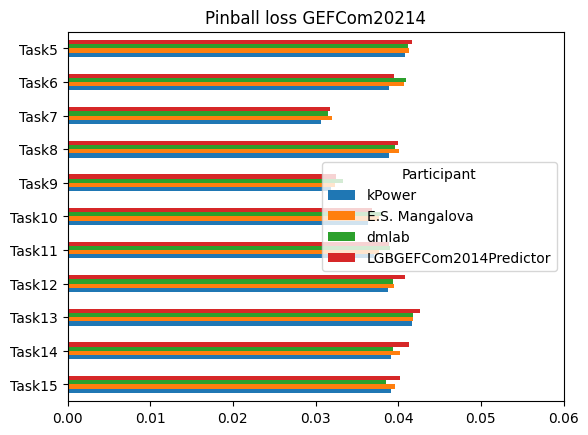

In [178]:
env.plot_results(losses, 
                 predictor_name="LGBGEFCom2014Predictor", 
                 drop_tasks=["Task1", "Task2", "Task3", "Task4"], 
                 top_teams=3)

In [33]:
file = "/Users/sebaheg/Documents/Github/treen/treen/data/gefcom2014/Provisional_Leaderboard_V2.xlsx"
df_p = pd.read_excel(file, index_col=0, header=[0,1])

In [55]:
df_t = 1 - df_scores/df_scores.loc["Benchmark - Wind"]
df_t = df_t.drop(columns=["Task1", "Task2", "Task3", "Task4"])
df_t = df_t.mean(axis=1).sort_values(ascending=False)

In [57]:
df_t.index.name = "Team"

In [61]:
df_p = df_p["Wind"].set_index("Team")["Rating"].dropna()

In [62]:
pd.concat([df_p, df_t], axis=1)

,Rating,0
Team,,
kPower,0.566125,0.563493
dmlab,0.558862,0.554009
E.S. Mangalova,0.557452,0.553742
C3 Green Team,0.554683,0.551426
Yao Zhang,0.547209,0.546282
UTES,0.507223,0.500964
pat1,0.468920,0.474793
Jiali Liu,0.458297,0.459049
Jérôme Collet,0.441852,0.466247
